Прежде чем запускать ноутбук, создайте и активируйте окружение из конфига environment.yml

In [1]:
import base64
import os
import shutil
import yaml

import cv2 as cv
import imageio
import imgaug as ia
import numpy as np
import pandas as pd
import ttach as tta
import torch

from argparse import Namespace

from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from pytorch_toolbelt import losses as L
from torch.utils.data import DataLoader

from train_classification_model import ClassificationModel
from train_segmentation_model import SegmentationModel
from utils.dataset import BacteriaDataset, LABEL_TO_IDX
from utils.helpers import dump, get_img_idxs, load, process_json
from utils.transforms import train_transform, valid_transform

Здесь можно задать GPU, которая будет использоваться при обучении и инференсе, путь к данным и num_workers у даталоадеров:

In [2]:
args = {
    'gpu': 0,
    'data_path': './data/',
    'num_workers': 16
}

hparams = Namespace(**args)

# 1 Описание решения

Классификация - se_resnext50_32x4d, 10 моделей, обученные на 10 фолдах. CrossEntropyLoss.

Сегментация - Unet c se_resnext50_32x4d backbone, 10 моделей, обученные на 10 фолдах. Лосс: 0.7 * BinaryFocalLoss + 0.3 * BinaryLovaszLoss.

Слабые аугментации: аффинное преобразование с зеркальным отражением изображения и масок, в случае если после преобразования появляется свободное место, и CoarseSaltAndPepper.

Пример аугментаций:

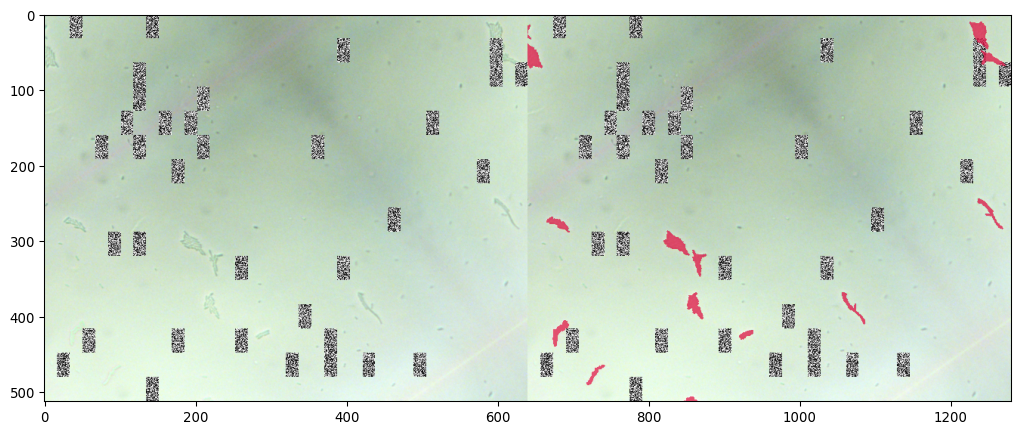

In [3]:
image_idx = '100'

image = imageio.imread(os.path.join(hparams.data_path, 'train', f'{image_idx}.png'))
mask, label = process_json(os.path.join(hparams.data_path, 'train', f'{image_idx}.json'))

image, mask = train_transform(image=image, segmentation_maps=mask)
mask = SegmentationMapsOnImage(mask, shape=image.shape)

ia.imshow(np.hstack([image, mask.draw_on_image(image)[0]]))

# 2 Классификация

Удаляем старые логи, если они есть:

In [4]:
!rm -rf lightning_logs

Вызываем скрипт, который обучает модель для классификации. Обучаем 10 моделей на 10 фолдах:

In [ ]:
for i in range(10):
    !python train_classification_model.py --gpu {hparams.gpu} --data_path {hparams.data_path} --fold {i} --num_workers {hparams.num_workers}

In [5]:
def copy_checkpoints(dest_folder):
    for version_folder in os.listdir('lightning_logs'):
        with open(os.path.join('lightning_logs', version_folder, 'hparams.yaml')) as inf:
            hparams = yaml.load(inf, Loader=yaml.FullLoader)
        
        path = os.path.join('lightning_logs', version_folder, 'checkpoints')
        filenames = os.listdir(path)
        
        assert len(filenames) == 1  # only one best checkpoint in folder
        
        for filename in filenames:
            ckpt_path = os.path.join(path, filename)
            shutil.copy(
                ckpt_path,
                os.path.join(dest_folder, f'seed{hparams["seed"]}_fold{hparams["fold"]}.ckpt')
            )

Из папки с логами, копируем чекпоинты с весами модели:

In [6]:
CLS_CKPT_FOLDER = 'classification_checkpoints'

In [7]:
!mkdir {CLS_CKPT_FOLDER}
copy_checkpoints(CLS_CKPT_FOLDER)

Загружаем тестовый датасет:

In [8]:
TEST_BATCH_SIZE = 4

test_path = os.path.join(hparams.data_path, 'test')
test_img_idxs = get_img_idxs(test_path)

test_images = []

for i, img_idx in enumerate(test_img_idxs):
    image_path = os.path.join(test_path, f'{img_idx}.png')
    image = imageio.imread(image_path)
    test_images.append(image)

test_images = np.stack(test_images)

test_dataset = BacteriaDataset(
    test_images,
    transform=valid_transform,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    num_workers=hparams.num_workers
)

In [9]:
# Selecting device for inference

if torch.cuda.is_available():
    torch.cuda.set_device(hparams.gpu)

device = f'cuda:{hparams.gpu}' if torch.cuda.is_available() else 'cpu'

In [10]:
def make_tta_preds(model, test_loader):
    model.freeze()
    model.eval()
    model.to(device)
    
    if isinstance(model, ClassificationModel):
        tta_model = tta.ClassificationTTAWrapper(model, tta.aliases.d4_transform(), merge_mode='mean')
    elif isinstance(model, SegmentationModel):
        tta_model = tta.SegmentationTTAWrapper(model, tta.aliases.d4_transform(), merge_mode='mean')
    
    all_logits = []
    
    for batch in test_loader:
        image = batch['image'].to(device)
        logits = tta_model(image)

        all_logits.append(logits.cpu())

    preds = torch.sigmoid(torch.cat(all_logits)).squeeze(1).numpy()
    
    return preds

Инференс с TTA для каждой из 10 модей и усреднение вероятностей:

In [11]:
fold_preds = []

for model_ckpt in os.listdir(CLS_CKPT_FOLDER):
    model_ckpt_path = os.path.join(CLS_CKPT_FOLDER, model_ckpt)
    
    model = ClassificationModel.load_from_checkpoint(model_ckpt_path)
    
    preds = make_tta_preds(model, test_loader)
    
    fold_preds.append(preds)
    
pred_probas = sum(fold_preds) / len(fold_preds)

Получаем метки классов:

In [12]:
pred_labels = pred_probas.argmax(axis=-1)

In [13]:
dump(pred_labels, 'pred_labels.pkl')

# 3 Сегментация

Удаляем папку с логами, оставшимися после обучения моделей для классификации:

In [14]:
!rm -rf lightning_logs

Обучаем Unet с se_resnext50_32x4d backbone. 10 моделей на 10 фолдах:

In [ ]:
for i in range(10):
    !python train_segmentation_model.py --gpu {hparams.gpu} --data_path {hparams.data_path} --seed 23 --fold {i} --num_workers {hparams.num_workers}

Копируем чекпоинты с весами из папки с логами:

In [16]:
SEGM_CKPT_FOLDER = 'segmentation_checkpoints'

In [17]:
!mkdir {SEGM_CKPT_FOLDER}
copy_checkpoints(SEGM_CKPT_FOLDER)

Делаем инференс с TTA для каждой модели и усредняем предсказанные маски:

In [19]:
fold_pred_masks = []

for model_ckpt in os.listdir(SEGM_CKPT_FOLDER):
    model_ckpt_path = os.path.join(SEGM_CKPT_FOLDER, model_ckpt)
    
    model = SegmentationModel.load_from_checkpoint(model_ckpt_path)
    
    pred_masks = make_tta_preds(model, test_loader)
    
    fold_pred_masks.append(pred_masks)
    
pred_masks = sum(fold_pred_masks) / len(fold_pred_masks)

In [20]:
dump(pred_masks, 'pred_masks.pkl')

# 4 Постпроцессинг масок (используем лик)

In [21]:
# pred_masks = load('pred_masks.pkl')
# pred_labels = load('pred_labels.pkl')

Копируем предсказанные маски.

В pred_masks_with_leak позже заменим часть масок на ликованные маски из sample_submission.

In [22]:
pred_masks_with_leak = pred_masks.copy()

In [23]:
sample_sub = pd.read_csv(
    os.path.join(hparams.data_path, 'sample_submission.csv'),
    dtype={'id': str}
)

Для каждого отдельного контура из sample_submisson будем считать Jaccard лосс, при этом смещая контур на несколько пикселей в разные стороны.

Запомнаем смещение, где лосс минимален. Получаем скорректированные маски, но часть из них будет пересекается.

На второй итерации отрисовываем все контуры, и двигаем их по одному, минимизируя лосс. Это исправит часть пересекающихся масок.

In [24]:
loss = L.JaccardLoss('binary', from_logits=False)

def calculate_loss(pred_mask, leaked_mask):
    with torch.no_grad():
        res = loss(torch.from_numpy(pred_mask), torch.from_numpy(leaked_mask)).item()
    return res

In [25]:
def correct_leaked_mask(leaked_mask, pred_mask):
    contours, hierarchy = cv.findContours(leaked_mask, cv.RETR_EXTERNAL , cv.CHAIN_APPROX_SIMPLE)
    contour_deltas = []
    
    # first iteration
    for contour in contours:
        min_x, min_y = contour.min(axis=0).flatten()
        max_x, max_y = contour.max(axis=0).flatten()

        x_shifts = np.arange(-8, 9)
        y_shifts = np.arange(-8, 9)

        x_shifts = x_shifts[np.logical_and(min_x + x_shifts > 0, max_x + x_shifts < 512)]
        y_shifts = y_shifts[np.logical_and(min_y + y_shifts > 0, max_y + y_shifts < 512)]

        deltas = []
        losses = []

        for x_shift in x_shifts:
            for y_shift in y_shifts:
                delta = np.array([x_shift, y_shift])

                corrected_contour = contour + delta

                corrected_mask = np.zeros((512, 512), dtype=np.int32)
                cv.fillPoly(corrected_mask, [corrected_contour], 1)

                deltas.append(delta)
                losses.append(calculate_loss(pred_mask, corrected_mask))

        losses = np.array(losses)
        contour_deltas.append(deltas[losses.argmin()])

    corrected_contours = [contours[i] + contour_deltas[i] for i in range(len(contours))]
    
    # second iteration
    for j, contour in enumerate(contours):
        
        temp_contours = [corrected_contours[i] for i in range(len(contours)) if i != j]
        temp_mask = np.zeros((512, 512), dtype=np.int32)
        cv.fillPoly(temp_mask, temp_contours, 1)
        
        
        min_x, min_y = contour.min(axis=0).flatten()
        max_x, max_y = contour.max(axis=0).flatten()
        
        x_shifts = np.arange(-8, 9)
        y_shifts = np.arange(-8, 9)

        x_shifts = x_shifts[np.logical_and(min_x + x_shifts > 0, max_x + x_shifts < 512)]
        y_shifts = y_shifts[np.logical_and(min_y + y_shifts > 0, max_y + y_shifts < 512)]
        
        deltas = []
        losses = []
        
        for x_shift in x_shifts:
            for y_shift in y_shifts:
                delta = np.array([x_shift, y_shift])

                corrected_contour = contour + delta
                corrected_mask = temp_mask.copy()
                cv.fillPoly(corrected_mask, [corrected_contour], 1)

                deltas.append(delta)
                losses.append(calculate_loss(pred_mask, corrected_mask))

        losses = np.array(losses)
        corrected_contours[j] = contour + deltas[losses.argmin()]

    
    corrected_mask = np.zeros((512, 512), dtype=np.int32)
    cv.fillPoly(corrected_mask, corrected_contours, 1)
    
    return corrected_mask

Декодирум маски с ликом из sample_submissson, корректируем их расположение и заменяем ими предсказанные вплоть до координаты 512 в pred_masks_with_leak:

In [26]:
for i in range(len(test_images)):
    binary_string = sample_sub['base64 encoded PNG (mask)'].values[i].encode('ascii')

    with open('temp.png', 'wb') as ouf:
        ouf.write(base64.b64decode(binary_string))

    pred_mask = pred_masks[i, :, :512]
    leaked_mask = (imageio.imread('temp.png') != 0).astype(np.uint8)[:, :512].transpose()
    
    corrected_leaked_mask = correct_leaked_mask(leaked_mask, pred_mask)
    pred_masks_with_leak[i, :, :512] = corrected_leaked_mask[:, :512]

Кодируем маски в base64:

In [27]:
def encode_masks(masks):
    encoded_pngs = []

    for mask in masks:
        imageio.imwrite('temp.png', (mask > 0.5).astype(np.uint8))

        with open('temp.png', 'rb') as inf:
            binary_string = base64.b64encode(inf.read())

        string = binary_string.decode('ascii')
        encoded_pngs.append(string)
        
    return encoded_pngs

In [28]:
encoded_pngs = encode_masks(pred_masks_with_leak)

Собираем предсказанные метки классов и закодированные маски в сабмит:

In [30]:
idx_to_label = {
    value: key for key, value in LABEL_TO_IDX.items()
}

In [31]:
test_labels = list(map(lambda x: idx_to_label[x], pred_labels))

In [32]:
sub = pd.DataFrame(data={
    'id': test_img_idxs,
    'class': test_labels,
    'base64 encoded PNG (mask)': encoded_pngs
})

In [33]:
sub.to_csv('submission.csv', index=False)

Посмотрим на полученные маски:

staphylococcus_epidermidis


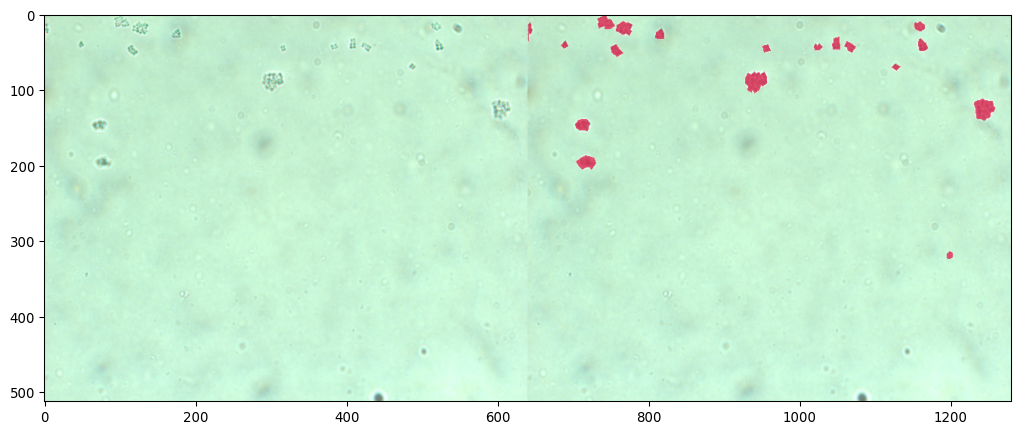

staphylococcus_epidermidis


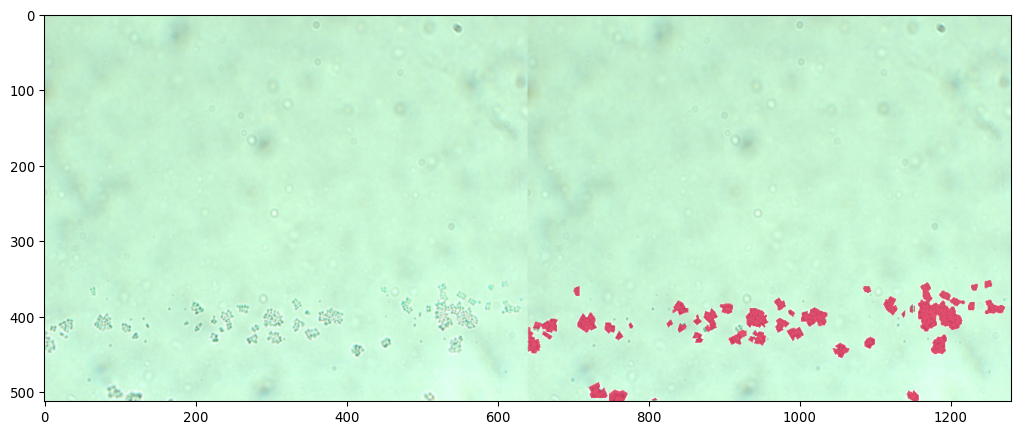

ent_cloacae


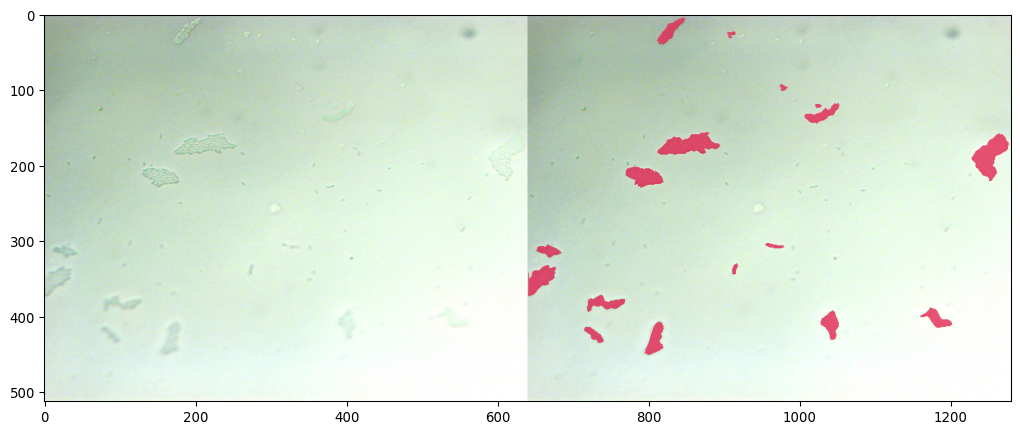

In [34]:
for i in range(3):
    image = test_images[i]
    mask = pred_masks_with_leak[i] > 0.5
    
    image, mask = valid_transform(image=image, segmentation_maps=mask)
    print(idx_to_label[pred_labels[i]])
    mask = SegmentationMapsOnImage(mask, shape=image.shape)
    ia.imshow(np.hstack([image, mask.draw_on_image(image)[0]]))